In [1]:
!pip install d2l==0.14.4
from d2l import torch as d2l
from zipfile import ZipFile
import torch
import copy
from torch import nn
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
import os

In [2]:
def read_data_nmt(lang):
    with open(lang + '.txt', 'r') as f:
        return f.read()

In [3]:
def preprocess_nmt(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = ['']

    tabs = 0
    for i, char in enumerate(text):
        if char == '\t':
            tabs += 1
        if tabs > 1 and char != '\n':
            continue
        elif tabs > 1:
            tabs = 0
        if i > 0:
            if char in set(',.!?') and text[i-1] != ' ':
                out.append(' ' + char)
                continue
        if char in set('¡¿') and text[i+1] != ' ':
            out.append(char + ' ')
            continue
        out.append(char)

    return ''.join(out)

In [4]:
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [5]:
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

In [6]:
def build_array(lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if not is_source:
        lines = [[vocab['<bos>']] + l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(dim=1)
    return array, valid_len

In [7]:
def load_data_nmt(lang, batch_size, num_steps, num_examples=1000):
    text = preprocess_nmt(read_data_nmt(lang))
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, num_steps, False)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return src_vocab, tgt_vocab, data_iter

In [8]:
def stringify_embedding(embedding):
    return embedding.weight.tolist()

def stringify_lstm(lstm):
    weights = []

    layer0 = [lstm.weight_ih_l0.tolist(), lstm.weight_hh_l0.tolist(), lstm.bias_ih_l0.tolist(), lstm.bias_hh_l0.tolist()]
    weights.append(layer0)
    if lstm.num_layers > 1:
        layer1 = [lstm.weight_ih_l1.tolist(), lstm.weight_hh_l1.tolist(), lstm.bias_ih_l1.tolist(), lstm.bias_hh_l1.tolist()]
        weights.append(layer1)
    if lstm.num_layers > 2:
        layer2 = [lstm.weight_ih_l2.tolist(), lstm.weight_hh_l2.tolist(), lstm.bias_ih_l2.tolist(), lstm.bias_hh_l2.tolist()]
        weights.append(layer2)
    if lstm.num_layers > 3:
        layer3 = [lstm.weight_ih_l3.tolist(), lstm.weight_hh_l3.tolist(), lstm.bias_ih_l3.tolist(), lstm.bias_hh_l3.tolist()]
        weights.append(layer3)
    if lstm.num_layers > 4:
        layer4 = [lstm.weight_ih_l4.tolist(), lstm.weight_hh_l4.tolist(), lstm.bias_ih_l4.tolist(), lstm.bias_hh_l4.tolist()]
        weights.append(layer4)
    if lstm.num_layers > 5:
        layer5 = [lstm.weight_ih_l5.tolist(), lstm.weight_hh_l5.tolist(), lstm.bias_ih_l5.tolist(), lstm.bias_hh_l5.tolist()]
        weights.append(layer5)
    if lstm.num_layers > 6:
        layer6 = [lstm.weight_ih_l6.tolist(), lstm.weight_hh_l6.tolist(), lstm.bias_ih_l6.tolist(), lstm.bias_hh_l6.tolist()]
        weights.append(layer6)
    if lstm.num_layers > 7:
        layer7 = [lstm.weight_ih_l7.tolist(), lstm.weight_hh_l7.tolist(), lstm.bias_ih_l7.tolist(), lstm.bias_hh_l7.tolist()]
        weights.append(layer7)
    if lstm.num_layers > 8:
        raise Exception("too many LSTM layers for current save implementation")
    
    return [lstm.input_size, lstm.hidden_size, lstm.num_layers, lstm.dropout, weights]

def stringify_linear(linear):
    if linear.bias == None:
        return [linear.in_features, linear.out_features, linear.weight.tolist()]
    else:
        return [linear.in_features, linear.out_features, linear.weight.tolist(), linear.bias.tolist()]

def stringify_dropout(dropout):
    return [dropout.p, dropout.inplace]

def stringify_mlp_attention(mlp):
    layers = []
    layers.append(stringify_linear(mlp.W_k))
    layers.append(stringify_linear(mlp.W_q))
    layers.append(stringify_linear(mlp.v))
    layers.append(stringify_dropout(mlp.dropout))
    
    return layers

In [9]:
def string_to_list(string):
    l, index = sub_string_to_list(string, 1)
    return l

def sub_string_to_list(string, index):
    i, l, s = index, [], []

    def append(value):
        if len(value) > 0:
            value = ''.join(s)
            try:
                value = float(value)
                if value == int(value):
                    value = int(value)
            except ValueError:
                value = str(value)
                if value == 'True':
                    value = True
                elif value == 'False':
                    value = False
            l.append(value)

    while i < len(string):
        if string[i] == '[':
            sublist, i = sub_string_to_list(string, i+1)
            l.append(sublist)
        elif string[i] == ',':
            append(s)
            s = []
            i += 2
        elif string[i] == ']':
            append(s)
            return l, i+1
        else:
            s.append(string[i])
            i += 1
    raise Exception("improperly formatted list")

def embedding_from_list(embedding, device):
    return nn.Embedding.from_pretrained(torch.tensor(embedding, device=device))

def lstm_from_list(lstm, device):
    rnn = nn.LSTM(lstm[0], lstm[1], lstm[2], dropout=lstm[3])
    rnn.weight_ih_l0 = nn.Parameter(torch.tensor(lstm[4][0][0], device=device))
    rnn.weight_hh_l0 = nn.Parameter(torch.tensor(lstm[4][0][1], device=device))
    rnn.bias_ih_l0 = nn.Parameter(torch.tensor(lstm[4][0][2], device=device))
    rnn.bias_hh_l0 = nn.Parameter(torch.tensor(lstm[4][0][3], device=device))

    if lstm[2] > 1:
        rnn.weight_ih_l1 = nn.Parameter(torch.tensor(lstm[4][1][0], device=device))
        rnn.weight_hh_l1 = nn.Parameter(torch.tensor(lstm[4][1][1], device=device))
        rnn.bias_ih_l1 = nn.Parameter(torch.tensor(lstm[4][1][2], device=device))
        rnn.bias_hh_l1 = nn.Parameter(torch.tensor(lstm[4][1][3], device=device))
    if lstm[2] > 2:
        rnn.weight_ih_l2 = nn.Parameter(torch.tensor(lstm[4][2][0], device=device))
        rnn.weight_hh_l2 = nn.Parameter(torch.tensor(lstm[4][2][1], device=device))
        rnn.bias_ih_l2 = nn.Parameter(torch.tensor(lstm[4][2][2], device=device))
        rnn.bias_hh_l2 = nn.Parameter(torch.tensor(lstm[4][2][3], device=device))
    if lstm[2] > 3:
        rnn.weight_ih_l3 = nn.Parameter(torch.tensor(lstm[4][3][0], device=device))
        rnn.weight_hh_l3 = nn.Parameter(torch.tensor(lstm[4][3][1], device=device))
        rnn.bias_ih_l3 = nn.Parameter(torch.tensor(lstm[4][3][2], device=device))
        rnn.bias_hh_l3 = nn.Parameter(torch.tensor(lstm[4][3][3], device=device))
    if lstm[2] > 4:
        rnn.weight_ih_l4 = nn.Parameter(torch.tensor(lstm[4][4][0], device=device))
        rnn.weight_hh_l4 = nn.Parameter(torch.tensor(lstm[4][4][1], device=device))
        rnn.bias_ih_l4 = nn.Parameter(torch.tensor(lstm[4][4][2], device=device))
        rnn.bias_hh_l4 = nn.Parameter(torch.tensor(lstm[4][4][3], device=device))
    if lstm[2] > 5:
        rnn.weight_ih_l5 = nn.Parameter(torch.tensor(lstm[4][5][0], device=device))
        rnn.weight_hh_l5 = nn.Parameter(torch.tensor(lstm[4][5][1], device=device))
        rnn.bias_ih_l5 = nn.Parameter(torch.tensor(lstm[4][5][2], device=device))
        rnn.bias_hh_l5 = nn.Parameter(torch.tensor(lstm[4][5][3], device=device))
    if lstm[2] > 6:
        rnn.weight_ih_l6 = nn.Parameter(torch.tensor(lstm[4][6][0], device=device))
        rnn.weight_hh_l6 = nn.Parameter(torch.tensor(lstm[4][6][1], device=device))
        rnn.bias_ih_l6 = nn.Parameter(torch.tensor(lstm[4][6][2], device=device))
        rnn.bias_hh_l6 = nn.Parameter(torch.tensor(lstm[4][6][3], device=device))
    if lstm[2] > 7:
        rnn.weight_ih_l7 = nn.Parameter(torch.tensor(lstm[4][7][0], device=device))
        rnn.weight_hh_l7 = nn.Parameter(torch.tensor(lstm[4][7][1], device=device))
        rnn.bias_ih_l7 = nn.Parameter(torch.tensor(lstm[4][7][2], device=device))
        rnn.bias_hh_l7 = nn.Parameter(torch.tensor(lstm[4][7][3], device=device))
    if lstm[2] > 8:
        raise Exception("too many LSTM layers for current read implementation")

    return rnn

def linear_from_list(linear, device):
    dense = nn.Linear(linear[0], linear[1], len(linear) > 3)
    dense.weight = nn.Parameter(torch.tensor(linear[2], device=device))
    if len(linear) > 3:
        dense.bias = nn.Parameter(torch.tensor(linear[3], device=device))
    
    return dense

def dropout_from_list(dropout):
    return nn.Dropout(dropout[0], dropout[1])

def mlp_attention_from_list(mlp, device):
    attention = MLPAttention(1, 1, 1, 1)
    attention.W_k = linear_from_list(mlp[0], device)
    attention.W_q = linear_from_list(mlp[1], device)
    attention.v = linear_from_list(mlp[2], device)
    attention.dropout = dropout_from_list(mlp[3])
    
    return attention

In [10]:
class MLPAttention(nn.Module):
    def __init__(self, key_size, query_size, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, units, bias=False)
        self.W_q = nn.Linear(query_size, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_len):
        query, key = self.W_q(query), self.W_k(key)
        features = query.unsqueeze(2) + key.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.v(features).squeeze(-1)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return torch.bmm(attention_weights, value)

In [11]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X)
        return out, state

    def stringify(self):
        return [stringify_embedding(self.embedding), stringify_lstm(self.rnn)]

In [12]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        out = self.dense(out).permute(1, 0, 2)
        return out, state
    
    def stringify(self):
        return [stringify_embedding(self.embedding), stringify_lstm(self.rnn), stringify_linear(self.dense)]

In [13]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            query = torch.unsqueeze(hidden_state[0][-1], dim=1)
            context = self.attention_cell(
                query, enc_outputs, enc_outputs, enc_valid_len)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_len]

    def stringify(self):
        return [stringify_mlp_attention(self.attention_cell), stringify_embedding(self.embedding), stringify_lstm(self.rnn), stringify_linear(self.dense)]

In [14]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError
    
    def stringify(self):
        raise NotImplementedError

class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError
    
    def stringify(self):
        raise NotImplementedError

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)
    
    def stringify(self):
        return [self.encoder.stringify(), self.decoder.stringify()]

In [15]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [16]:
def masked_softmax(X, valid_len):
    """Perform softmax by filtering out some elements."""
    if valid_len is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_len.dim() == 1:
            valid_len = torch.repeat_interleave(valid_len, repeats=shape[1],
                                                dim=0)
        else:
            valid_len = valid_len.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_len, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [17]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss

In [18]:
def minimize_loss(lang, device):
    best_params = []
    for num_examples in [50000]:
        best_rate = 0
        best_rate_params = []
        for batch_size in [192, 256]:
            num_steps = 10
            src_vocab, tgt_vocab, train_iter = load_data_nmt(lang, batch_size, num_steps, num_examples)
            for embed_size in [8, 16]:
                for num_hiddens in [96, 128]:
                    for num_layers in [8]:
                        for dropout in [0.1]:
                            encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
                            decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
                            model = EncoderDecoder(encoder, decoder)
                            for lr in [0.0025]:
                                print('Embed size', embed_size, 'For batch size', batch_size)
                                graph = train(model, train_iter, lr, 20, device)
                                loss_rate = graph[9][1] - graph[19][1]
                                if loss_rate > best_rate:
                                    best_rate_params = [embed_size, num_hiddens, num_layers,
                                                        dropout, batch_size, num_steps,
                                                        num_examples, lr]
                                    best_rate = loss_rate
        best_params.append([num_examples, best_rate_params])
    return best_params

In [19]:
def train(model, data_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    graph = []
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            print(X)
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
        graph.append([epoch, metric[0]/metric[1]])
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')
    return graph

In [20]:
def sort_highest_k(y, k, device):
    y_red = y
    result = torch.tensor([[0, 0, 0]], device=device) # probability, token index, sequence index
    for k_i in range(k):
        highest = y_red[0]
        highest_index = 0
        for y_i in range(len(y_red)):
            if y_red[y_i][0] > highest[0]:
                highest = y_red[y_i]
                highest_index = y_i
        result = torch.cat((result, highest.reshape(1,3)), dim=0)
        y_red = torch.cat((y_red[:highest_index], y_red[highest_index+1:]), dim=0)
    return result[1:]

In [21]:
def completed(prediction, eos):
    if len(prediction[0]) > 0:
        return True if prediction[0][-1] == eos else False
    return False

In [65]:
def predict(model, src_sentence, src_vocab, tgt_vocab, num_steps, search_width, device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.tensor(src_tokens, dtype=torch.long, device=device)
    enc_outputs = model.encoder(torch.unsqueeze(enc_X, dim=0), enc_valid_len)

    states, inputs, predictions, state_logs = [], [], [], []
    for _ in range(search_width):
#         states.append([model.decoder.init_state(enc_outputs, enc_valid_len)])
#         for i in range(num_steps):
#             state_set.append(0)
#         states.append(state_set)
        states.append(model.decoder.init_state(enc_outputs, enc_valid_len))
        inputs.append(torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0))
        predictions.append([[], 1.0, 0])
    eos = tgt_vocab['<eos>']
    
    def add_state_to_log(state, prediction):
        found = False
        new_index = 0
        for state_log in state_logs:
            if prediction[2] == state_log[0]:
                found = True
                state_log[1].append(state)
                break
            if state_log[0] > new_index:
                new_index = state_log[0]
        
        if not found:
            state_logs.append([new_index, [state]])
            
    def get_log(prediction):
        for state_log in state_logs:
            if state_log[0] == prediction[2]:
                return state_log
    
#     def last_state_index(state_set):
#         last = state_set[0]
#         for element in state_set[1:]:
            

    for i in range(num_steps):
        y = torch.tensor([], device=device) # probability, token index, sequence index
        for k in range(search_width if i > 0 else 1):
            if completed(predictions[k], eos): continue
#             y_sub, state_sub = model.decoder(inputs[k], states[k][len(states[k])-1])
#             states[k].append(state_sub)
#             print(states[k][i])
            y_sub, new_state = model.decoder(inputs[k], states[k])
            states[k] = new_state
            add_state_to_log(new_state, predictions[k])
#             y_sub, state_sub = model.decoder(inputs[k], states[k][-1])
#             states[k].append(state_sub)
            for y_sub_i in range(y_sub.numel()):
                y = torch.cat((y, torch.tensor([y_sub[0][0][y_sub_i], y_sub_i, k]).reshape(1,3)), dim=0)
        y_sorted = sort_highest_k(y, len(inputs), device)
        
        new_predictions, new_states, new_inputs = [], [], []
        done_predictions, done_states = [], []
        for y_i in range(y_sorted.shape[0]):
            new_prediction = copy.deepcopy(predictions[int(y_sorted[y_i][2])])
            new_prediction[0].append(y_sorted[y_i][1].squeeze(dim=0).type(torch.int32).item())
            new_prediction[1] = new_prediction[1]*y_sorted[y_i][0].item()
            if not completed(new_prediction, eos):
                new_predictions.append(new_prediction)
                new_states.append(states[int(y_sorted[y_i][2])])
                new_inputs.append(torch.tensor([[int(y_sorted[y_i][1])]], dtype=torch.long, device=device))
            else:
                done_predictions.append(new_prediction)
                done_states.append(states[int(y_sorted[y_i][2])])
        for p in done_predictions:
            new_predictions.append(p)
        for s in done_states:
            new_states.append(s)
        for k in range(len(predictions)):
            if completed(predictions[k], eos):
                new_predictions.append(predictions[k])
                new_states.append(states[k])
        predictions, states, inputs = new_predictions, new_states, new_inputs

        if len(inputs) == 0: break

    best_prediction = predictions[0]
#     best_state = states[0]
    for i in range(1, len(predictions)):
        if predictions[i][1] > best_prediction[1]:
            best_prediction = predictions[i]
#             best_state = states[i]
    return ' '.join(tgt_vocab.to_tokens(best_prediction[0][:-1])), get_log(best_prediction)[1]

In [23]:
def save_model(lang, filename, model, num_examples):
    path = 'A4-2_' + lang + '_model_' + filename + '.txt'
    with open(path, 'w') as f:
        f.write(str([model.stringify(), num_examples]))

def load_model(lang, filename, attention, device):
    path = 'A4-2_' + lang + '_model_' + filename + '.txt'
    with open(path, 'r') as f:
        model_list = string_to_list(f.read())
        
        encoder = Seq2SeqEncoder(1, 1, 1, 1)
        encoder.embedding = embedding_from_list(model_list[0][0][0], device)
        encoder.rnn = lstm_from_list(model_list[0][0][1], device)
        
        decoder = Seq2SeqAttentionDecoder(1, 1, 1, 1)
        if attention:
            decoder.attention_cell = mlp_attention_from_list(model_list[0][1][0], device)
            decoder.embedding = embedding_from_list(model_list[0][1][1], device)
            decoder.rnn = lstm_from_list(model_list[0][1][2], device)
            decoder.dense = linear_from_list(model_list[0][1][3], device)
        else:
            decoder = Seq2SeqDecoder(1, 1, 1, 1)
            decoder.embedding = embedding_from_list(model_list[0][1][0], device)
            decoder.rnn = lstm_from_list(model_list[0][1][1], device)
            decoder.dense = linear_from_list(model_list[0][1][2], device)
        
        model = EncoderDecoder(encoder, decoder)
        
        return model, num_examples

def save_loss(lang, filename, graph):
    path = 'A4-2_' + lang + '_loss_' + filename + '.csv'
    with open(path, 'w') as f:
        csv = ""
        for p in graph:
            csv = csv + (str(p[0]) + "," + str(p[1]) + "\n")
        f.write(csv[:-1])

def save_best_params(lang, filename, best_params):
    path = 'A4-2_' + lang + '_params_' + filename + '.csv'
    with open(path, 'w') as f:
        header = "Parameter"
        embed = "Embed Size"
        hiddens = "Hiddens"
        layers = "Layers"
        dropout = "Dropout"
        batch = "Batch Size"
        steps = "Steps"
        examples = "Examples"
        learn = "Learn Rate"
        for best_param in best_params:
            header = header + "," + str(best_param[0])
            embed = embed + "," + str(best_param[1][0])
            hiddens = hiddens + "," + str(best_param[1][1])
            layers = layers + "," + str(best_param[1][2])
            dropout = dropout + "," + str(best_param[1][3])
            batch = batch + "," + str(best_param[1][4])
            steps = steps + "," + str(best_param[1][5])
            examples = examples + "," + str(best_param[1][6])
            learn = learn + "," + str(best_param[1][7])
        f.write(header+"\n"+embed+"\n"+hiddens+"\n"+layers+"\n"+dropout+"\n"+batch+"\n"+
               steps+"\n"+examples+"\n"+learn)

In [24]:
def select_configuration(filename):
    embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
    batch_size, num_steps, num_examples = 64, 10, 1000
    lr, num_epochs, search_width, device = 0.005, 100, 3, d2l.try_gpu()
    
    if filename == '2k':
        embed_size, num_hiddens, num_layers, dropout = 16, 96, 4, 0.1
        batch_size, num_steps, num_examples = 128, 10, 2000
        lr, num_epochs, search_width, device = 0.0025, 400, 3, d2l.try_gpu()
    elif filename == '10k':
        embed_size, num_hiddens, num_layers, dropout = 8, 96, 8, 0.1
        batch_size, num_steps, num_examples = 192, 10, 10000
        lr, num_epochs, search_width, device = 0.0025, 500, 3, d2l.try_gpu()
    elif filename == '10k-noa':
        embed_size, num_hiddens, num_layers, dropout = 8, 96, 8, 0.1
        batch_size, num_steps, num_examples = 192, 10, 10000
        lr, num_epochs, search_width, device = 0.0025, 500, 3, d2l.try_gpu()
    elif filename == '50k':
        embed_size, num_hiddens, num_layers, dropout = 16, 128, 8, 0.1
        batch_size, num_steps, num_examples = 256, 10, 50000
        lr, num_epochs, search_width, device = 0.0025, 200, 3, d2l.try_gpu()
    elif filename == '50k-nod':
        embed_size, num_hiddens, num_layers, dropout = 16, 128, 8, 0.0
        batch_size, num_steps, num_examples = 256, 10, 50000
        lr, num_epochs, search_width, device = 0.0025, 200, 3, d2l.try_gpu()
    elif filename == '50k-nod-noa':
        embed_size, num_hiddens, num_layers, dropout = 16, 128, 8, 0.0
        batch_size, num_steps, num_examples = 256, 10, 50000
        lr, num_epochs, search_width, device = 0.0025, 200, 3, d2l.try_gpu()
    elif filename == '50k-nod-long':
        embed_size, num_hiddens, num_layers, dropout = 16, 128, 8, 0.0
        batch_size, num_steps, num_examples = 256, 10, 50000
        lr, num_epochs, search_width, device = 0.0025, 500, 3, d2l.try_gpu()
    
    return embed_size, num_hiddens, num_layers, dropout, batch_size, num_steps, \
        num_examples, lr, num_epochs, search_width, device

In [41]:
# Spanish ('spa') model filenames
#   '10k' - low quality translation, gets some words correct
#   '50k' - low quality translation, gets some words correct (or related)
#   '50k-nod' - medium quality translation, gets shorter phrases correct
#   '50k-nod-noa' - low quality translation, very few words correct
#   '50k-nod-long' - low quality translation, longer phrases have more words correct
# Romanian ('ron') model filenames
#   '10k' - low quality translation, gets some scattered words correct
#   '10k-noa' - poor translation, only some related words
# Note that the "attention" variable needs to be adjusted accordingly to the model
lang, filename = 'spa', '50k-nod'
train_model, save_graph, learn_parameters = False, False, False
attention, graph_attention = True, True
embed_size, num_hiddens, num_layers, dropout, batch_size, num_steps, \
    num_examples, lr, num_epochs, search_width, device = select_configuration(filename)

if learn_parameters:
    save_best_params(lang, filename, minimize_loss(lang, device))
else:
    if train_model:
        src_vocab, tgt_vocab, train_iter = load_data_nmt(lang, batch_size, num_steps, num_examples)
        encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
        if attention:
            decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
        else:
            decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
        model = EncoderDecoder(encoder, decoder)
        graph = train(model, train_iter, lr, num_epochs, device)
        if save_graph:
            save_loss(lang, filename, graph)
        save_model(lang, filename, model, num_examples)
    else:
        model, num_examples = load_model(lang, filename, attention, device)
        src_vocab, tgt_vocab, train_iter = load_data_nmt(lang, batch_size, num_steps, num_examples)

Welcome home . => bienvenida a casa .
Wow ! => ¡ órale !
I'm OK . => he terminado .
I won ! => ¡ he ganado !
The party has started . => la <unk> se está quemando .
My hovercraft is full of eels . => tu auto está en <unk> en la <unk> .
It is an honor to be here . => hace tan difícil como divertido .
What is mine is also yours . => lo . la <unk> es la favor .
When they come looking , take a right turn and hide . => ¿ cuándo puedo <unk> a comer ?
Build your own Spanish to English Translation System . => la cosa que él usted unos <unk> como razonable


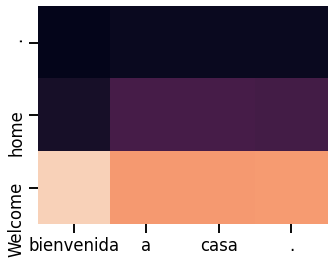

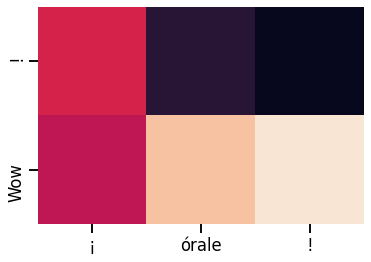

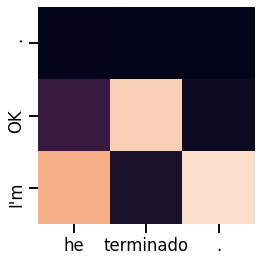

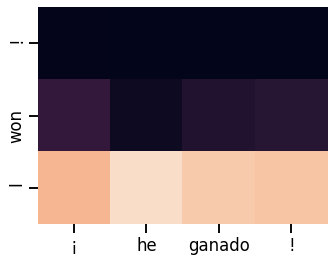

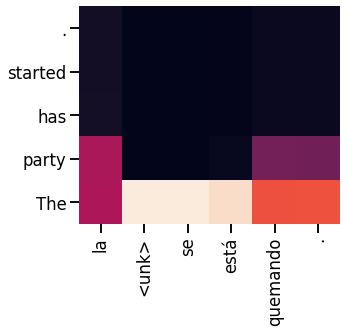

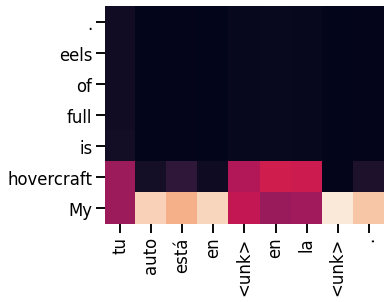

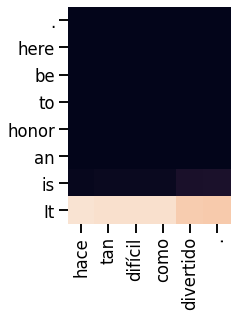

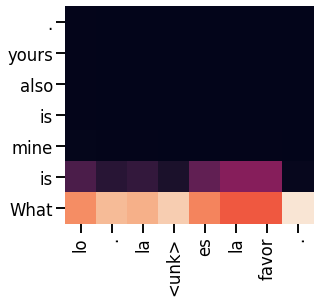

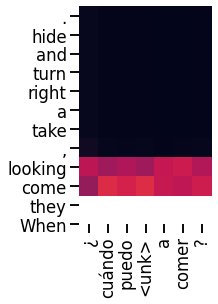

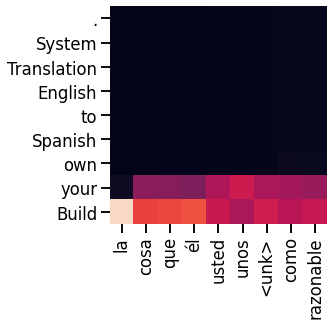

In [67]:
test_sentences = [
    'Welcome home .',
    'Wow !',
    "I'm OK .",
    'I won !',
    'The party has started .',
    'My hovercraft is full of eels .',
    'It is an honor to be here .',
    'What is mine is also yours .',
    'When they come looking , take a right turn and hide .',
    'Build your own Spanish to English Translation System .'
                 ]
for sentence in test_sentences:
    prediction, state = predict(model, sentence, src_vocab, tgt_vocab, num_steps, search_width, device)
    print(sentence + ' => ' + prediction)
#     print(state)
    if attention and graph_attention:
        prediction = prediction.split(' ')
        prediction_tokenized = []
        for step in range(len(prediction)):
            prediction_tokenized.append(tgt_vocab[prediction[step]])
        prediction_tokenized = torch.tensor(prediction_tokenized, device=device)
        
        def flip_x_y(matrix):
            x_dim, y_dim = matrix.shape[0], matrix.shape[1]
            flattened = matrix.reshape(-1)
            
            flipped = []
            for y in range(y_dim):
                row = []
                for x in range(x_dim):
                    row.append(matrix[x][(y_dim-y)-1].item())
                flipped.append(row)
            return torch.tensor(flipped, device=device)
        
        X = model.decoder.embedding(prediction_tokenized)
        attn = model.decoder.attention_cell
        step_output = []
        for i in range(len(prediction)):
            x = X[i]
            enc_outputs, hidden_state, enc_valid_len = state[i]
            query = torch.unsqueeze(hidden_state[0][-1], dim=1)
            query, key = attn.W_q(query), attn.W_k(enc_outputs)
            features = query.unsqueeze(2) + key.unsqueeze(1)
            features = torch.tanh(features)
            scores = attn.v(features).squeeze(-1)
            attention_weights = attn.dropout(masked_softmax(scores, enc_valid_len)).reshape(-1)[:len(sentence.split(' '))]
            step_output.append(attention_weights.tolist())
        step_output = flip_x_y(torch.tensor(step_output, device=device))
        fig, ax = plt.subplots()
        seaborn.heatmap(step_output, xticklabels=prediction, square=True, yticklabels=sentence.split(' ')[::-1], vmin=0.0, vmax=1.0, cbar=False, ax=ax)

In [ ]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(X[indexVal][0].cpu().detach().numpy(), cmap='RdBu_r')
ax.set_aspect(1)
ax.set_title("Object of type " + str(y[indexVal].item()) + " layer " + str((layerCounter % 2) + 1) + " (first filter) activations")
fig.colorbar(pcm, ax=ax)

# MLP Attention
def forward(self, query, key, value, valid_len):
    query, key = self.W_q(query), self.W_k(key)
    features = query.unsqueeze(2) + key.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.v(features).squeeze(-1)
    attention_weights = self.dropout(masked_softmax(scores, valid_len))
    return torch.bmm(attention_weights, value)

# EncoderDecoder
def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args)
    return self.decoder(dec_X, dec_state)

# Decoder
def forward(self, X, state):
    enc_outputs, hidden_state, enc_valid_len = state
    X = self.embedding(X).permute(1, 0, 2)
    outputs = []
    for x in X:
        query = torch.unsqueeze(hidden_state[0][-1], dim=1)
        context = self.attention_cell(
            query, enc_outputs, enc_outputs, enc_valid_len)
        x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
        out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
        outputs.append(out)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_len]